In [1]:
from pathlib import Path
import pandas as pd
# ── paths ─────────────────────────────────────────────────────────────
BASE = Path("/media/sagark24/New Volume/MERGE CDIS")
SCADA_FOLDERS = [
    BASE / "2-Year-data/200/200",
    BASE / "2-Year-data/200-400/200-400",
    BASE / "2-Year-data/400-600/400-600",
    BASE / "2-Year-data/600-759/600-759",
    BASE / "2-Year-data/SCADA_JAN_24_TO_APR_25",
]
FAULT_CSV   = BASE / "IPYNB_FILE/DATA_GENERATION/HT_fault_cable_info_processed_without_affected.csv"
CABLE_META  = BASE / "IPYNB_FILE/DATA_GENERATION/SWNO_MASTER_COMBINED_FULL_FINAL3.csv"

# def norm_sw(x:str|int|float|None) -> str:
#     """Uniform “S123” / “SWNO_123” / 123 →  'SW123'."""
#     if pd.isna(x): return ""
#     s = str(x).strip().upper().lstrip("0")
#     if s.startswith("SW"): return s
#     if s.startswith("S"):  return "SW" + s[1:]
#     return "SW" + s


In [2]:
import pandas as pd

htcable = pd.read_csv(CABLE_META)
fault = pd.read_csv(FAULT_CSV, parse_dates=['TIME_OUTAGE'])


In [3]:
faults_per_switch = fault['SWITCH_NO'].value_counts()
print(faults_per_switch.head())


SWITCH_NO
25325    49
32857    49
30462    44
6531     44
3608     40
Name: count, dtype: int64


In [4]:
# Count faults per month
fault['MONTH'] = fault['TIME_OUTAGE'].dt.to_period('M')
faults_per_month = fault.groupby('MONTH').size()
print(faults_per_month)


MONTH
2016-07      2
2016-08      3
2016-09     20
2016-10     37
2016-11    105
          ... 
2024-12    115
2025-01    131
2025-02    109
2025-03    152
2025-04      3
Freq: M, Length: 106, dtype: int64


/tmp/ipykernel_1148094/194577225.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  fault['MONTH'] = fault['TIME_OUTAGE'].dt.to_period('M')


In [5]:
avg_repair = fault['TIME_DIFFERENCE_HOURS'].mean()
median_repair = fault['TIME_DIFFERENCE_HOURS'].median()
print(f"Average Repair Time (hr): {avg_repair:.2f}, Median Repair Time (hr): {median_repair:.2f}")


Average Repair Time (hr): 8.21, Median Repair Time (hr): 0.52


In [6]:
faults_per_station = fault['STATION_NAME'].value_counts()
print(faults_per_station.head())


STATION_NAME
SAKI REC-STN        273
CHEMBUR REC-STN     250
VIKHROLI REC-STN    249
AMBIVLI REC-STN     239
MIRA REC-STN        235
Name: count, dtype: int64


In [7]:
# Sometimes SWITCH_NO in fault data matches SOURCE_SWITCH_ID or DESTINATION_SWITCH_ID
merged = fault.merge(
    htcable,
    left_on='SWITCH_NO',
    right_on='SOURCE_SWITCH_ID',
    how='left',
    suffixes=('', '_ht')
)


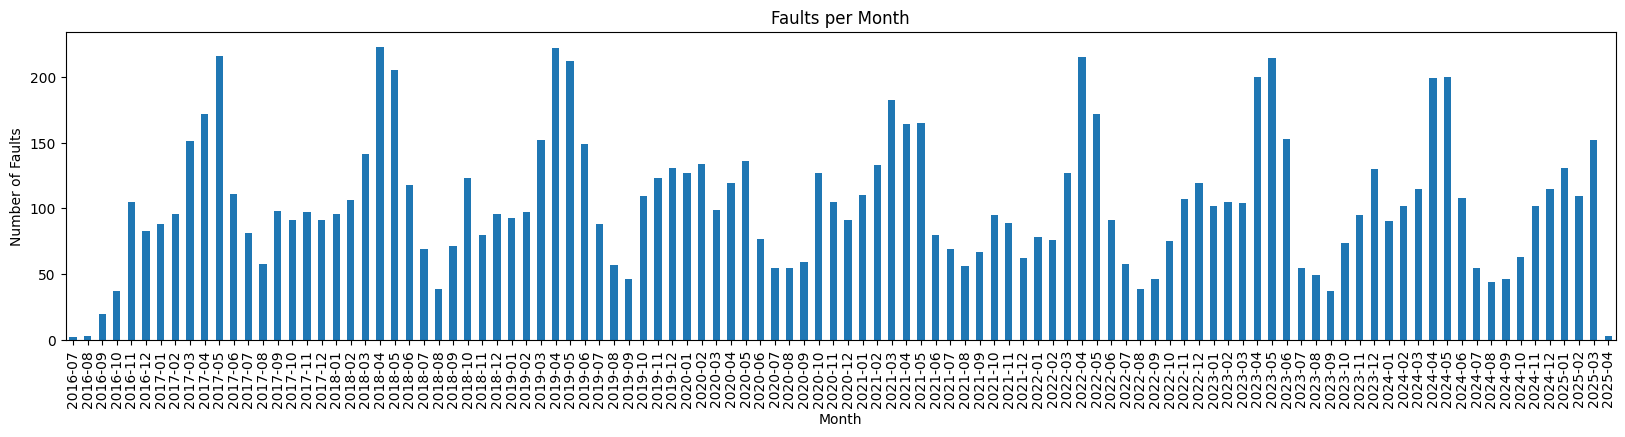

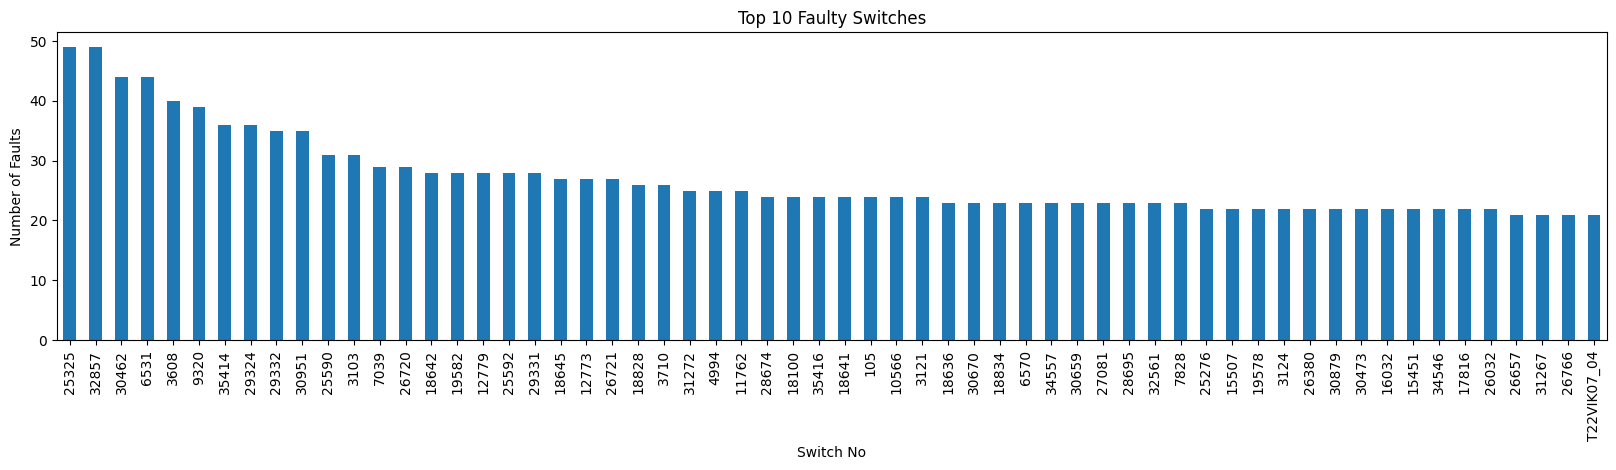

In [8]:
import matplotlib.pyplot as plt

# Faults per month
faults_per_month.plot(kind='bar', figsize=(20,4), title='Faults per Month')
plt.ylabel("Number of Faults")
plt.xlabel("Month")
plt.show()

# Faults per switch (top 10)
faults_per_switch.head(60).plot(kind='bar',figsize=(20,4), title='Top 10 Faulty Switches')
plt.ylabel("Number of Faults")
plt.xlabel("Switch No")
plt.show()


In [9]:
# # Group by switch and month to see trends
# fault.groupby(['SWITCH_NO', 'MONTH']).size().unstack(fill_value=0).plot(kind='bar', stacked=True, figsize=(20,6))
# plt.title("Monthly Fault Distribution per Switch")
# plt.show()


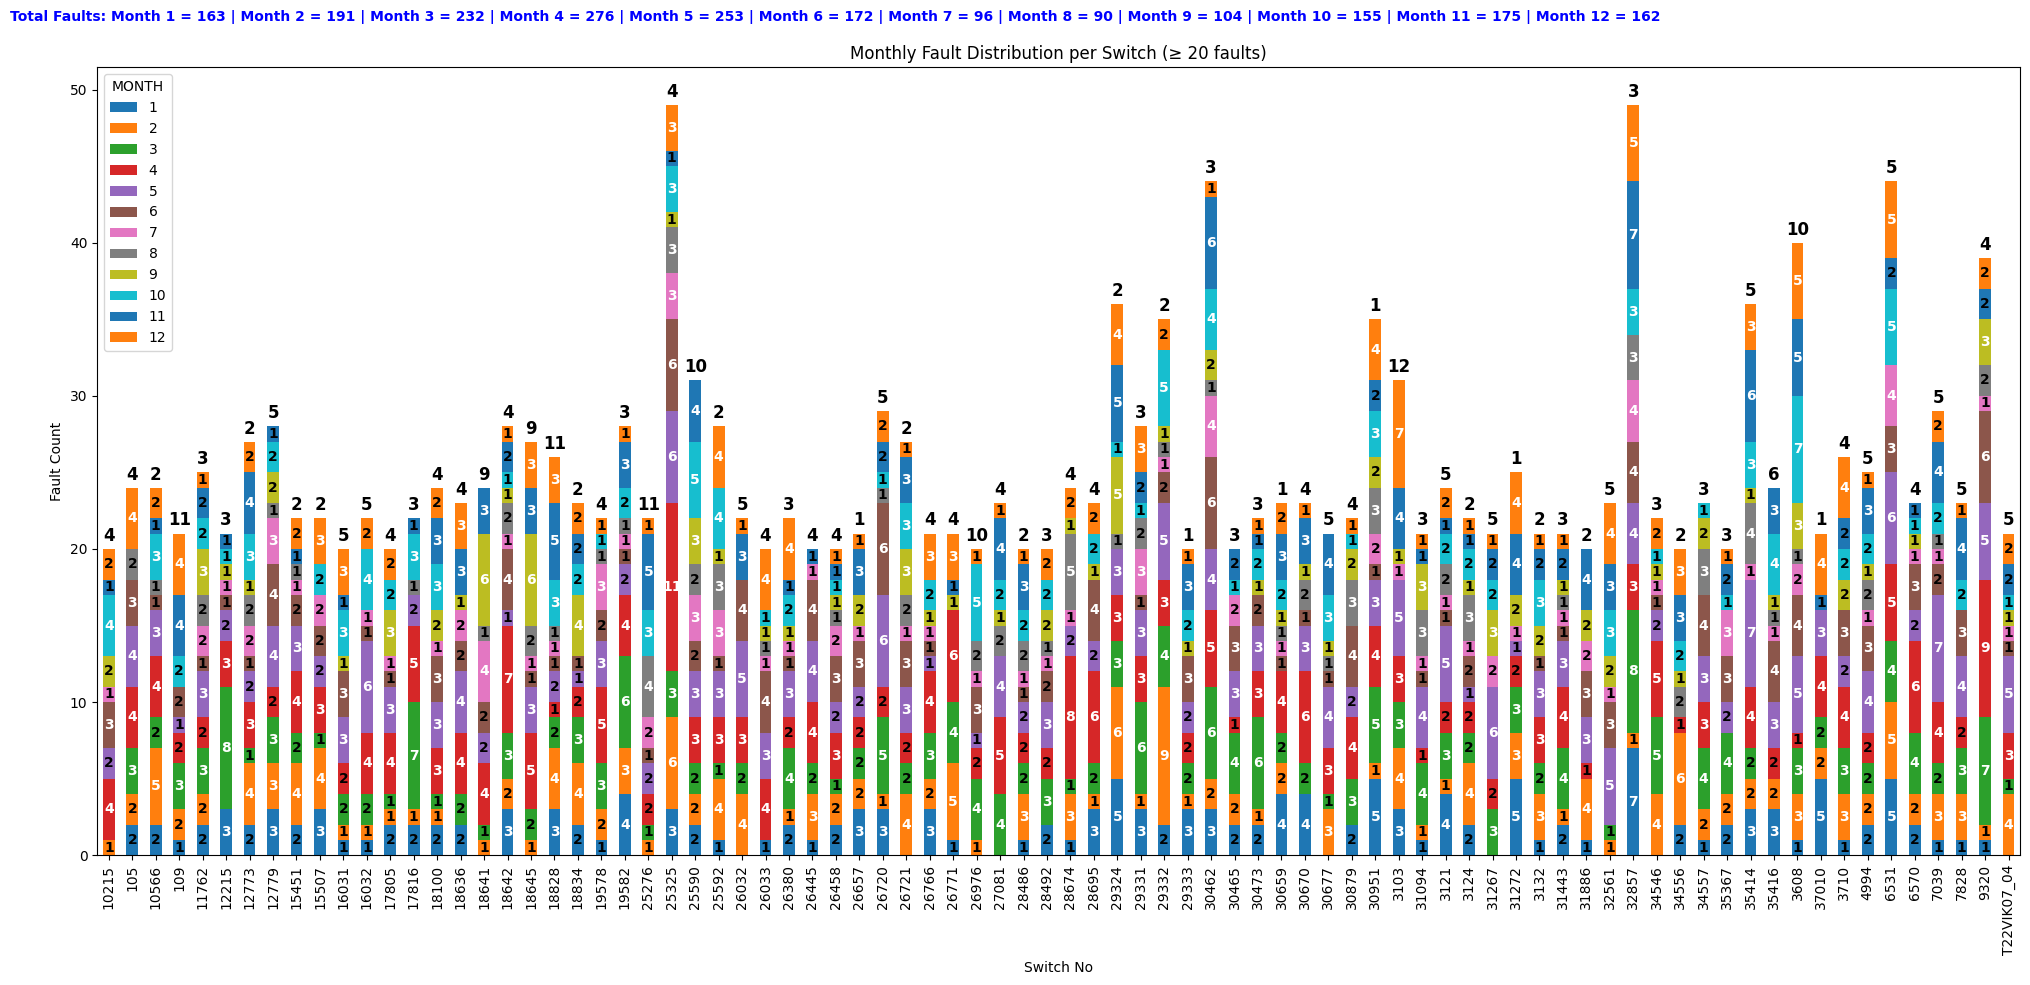

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract month if needed
fault['MONTH'] = fault['TIME_OUTAGE'].dt.month

grouped = fault.groupby(['SWITCH_NO', 'MONTH']).size().unstack(fill_value=0)
switch_totals = grouped.sum(axis=1)
threshold = 20
filtered = grouped[switch_totals >= threshold]

ax = filtered.plot(kind='bar', stacked=True, figsize=(20, 10))
plt.title("Monthly Fault Distribution per Switch (≥ {} faults)".format(threshold))
plt.ylabel("Fault Count")
plt.xlabel("Switch No")

# Annotate each segment (every month in every bar)
for i, (switch, row) in enumerate(filtered.iterrows()):
    bottom = 0
    for month in filtered.columns:
        count = row[month]
        if count > 0:
            ax.annotate(
                str(count),
                xy=(i, bottom + count / 2),
                ha='center',
                va='center',
                fontsize=10,
                color='white' if count > 2 else 'black',
                fontweight='bold'
            )
        bottom += count

# Annotate the highest month number for each bar, above the bar
for i, (switch, row) in enumerate(filtered.iterrows()):
    if row.sum() > 0:
        max_month = row.idxmax()
        total_height = row.sum()
        ax.annotate(
            str(max_month),
            xy=(i, total_height),
            xytext=(0, 3),
            textcoords='offset points',
            ha='center', va='bottom',
            fontsize=12, color='black', fontweight='bold'
        )

# Calculate and display total faults for each month at the top as text
month_totals = filtered.sum(axis=0)  # Series: index=month, value=total
month_totals_str = " | ".join([f"Month {m} = {v}" for m, v in month_totals.items()])
plt.gcf().text(0.4, 0.98, "Total Faults: " + month_totals_str, fontsize=10, ha='center', va='top', color='blue', fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the top text
plt.show()


FOR 22 AND 33 KV

/tmp/ipykernel_70146/976721171.py:55: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  scada["MONTH"] = scada["SYSTIME"].dt.to_period("M")


 SCADA load features available for 302 switches.
  Faults retained after SCADA‑switch filter: 861

  Final merged table: 1,042 rows

--- Faults by cable type ---
 CABLETYPE
XLPE    913
PILC     57
Name: count, dtype: int64

--- Faults by segment length (m) ---
 count      970.000000
mean      4530.252288
std       2885.233493
min          4.211000
25%       2856.079000
50%       4584.800000
75%       6469.413000
max      10875.411000
Name: MEASUREDLENGTH, dtype: float64

--- Repeat faults (within 1 month) ---
 REPEAT_FAULT_1M
False    869
True     173
Name: count, dtype: int64

--- Peak load distribution ---
 count      91.000000
mean      242.464771
std       188.189103
min         0.000000
25%       168.825470
50%       232.316650
75%       262.806580
max      1499.011108
Name: PEAK_LOAD, dtype: float64


/tmp/ipykernel_70146/976721171.py:96: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  fault["FAULT_MONTH"]    = fault["TIME_OUTAGE"].dt.to_period("M")


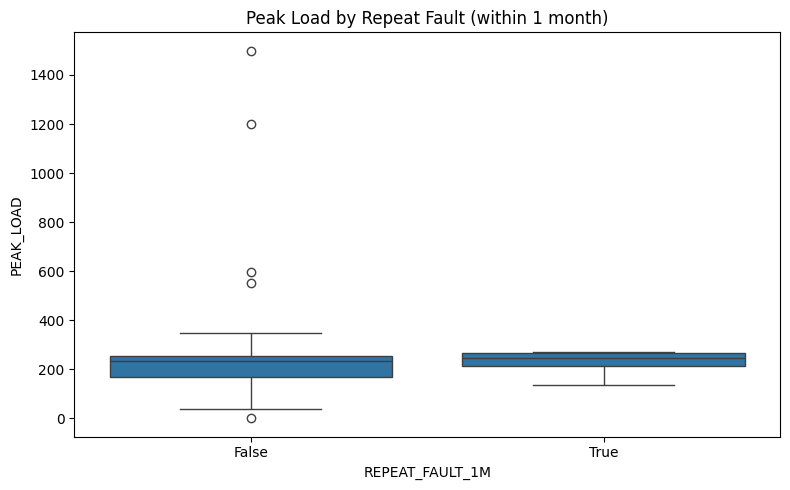

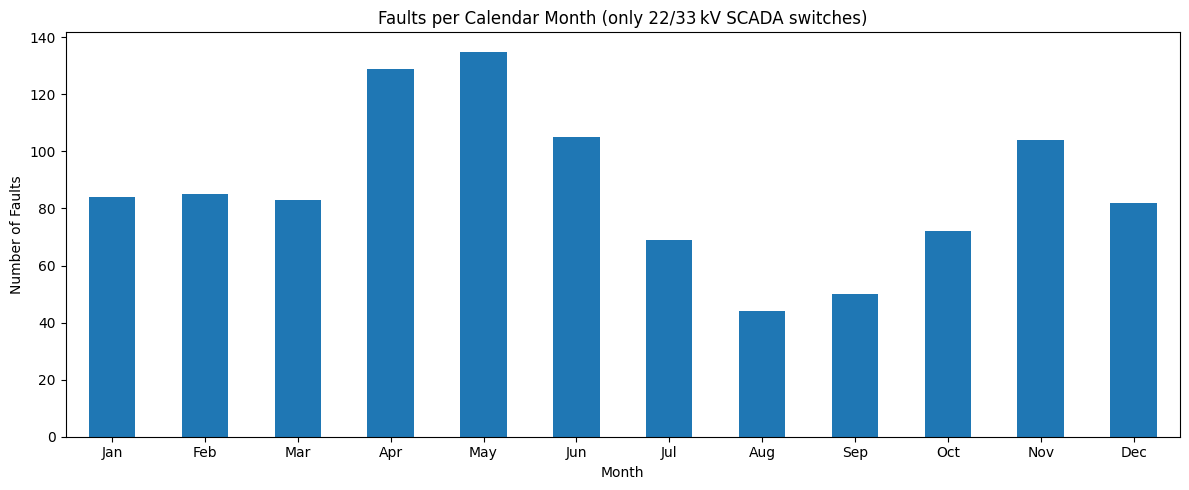


  Saved merged dataset → fault_cable_merged_SCADAonly.csv


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
fault_scada_merge_analysis.py
────────────────────────────
• Reads multi‑file SCADA current data (22 / 33 kV, phase‑current “I” rows).
• Reads HT cable meta‑data and fault logs.
• Keeps *only* faults on switches for which SCADA load features exist.
• Merges (cable ➝ fault ➝ monthly SCADA) and performs quick EDA / plots.
"""

import pandas as pd
from pathlib import Path
import glob
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns


MAX_WORKERS = 10

# ── CONSTANTS 
COLUMNS = ["VOLTAGE", "SWNO", "SYSTIME", "PARA", "VALUE"]


# 1.  LOAD & FILTER 22 / 33 kV SCADA  (phase‑current “I” only)

scada_files = []
for folder in SCADA_FOLDERS:
    scada_files.extend(glob.glob(str(folder / "*.csv")))

def filter_scada(df: pd.DataFrame) -> pd.DataFrame:
    """Return rows that are 22/33 kV *and* current (PARA == 'I')."""
    return df[
        df["VOLTAGE"].astype(str).str.contains(r"\b22\b|\b33\b", case=False, regex=True)
        & (df["PARA"].astype(str).str.upper() == "I")
    ]

def read_scada_file(f: str) -> pd.DataFrame:
    """Read a single CSV safely, return filtered DataFrame (or empty on error)."""
    try:
        df = pd.read_csv(f, usecols=COLUMNS, low_memory=False)
        return filter_scada(df)
    except Exception as e:
        print(f"  Failed to read {f}: {e}")
        return pd.DataFrame(columns=COLUMNS)

with concurrent.futures.ProcessPoolExecutor(max_workers=MAX_WORKERS) as exe:
    scada_list = list(exe.map(read_scada_file, scada_files))

scada = pd.concat(scada_list, ignore_index=True)
scada["SWNO"] = scada["SWNO"].astype(str).str.upper().str.strip()
scada["SYSTIME"] = pd.to_datetime(scada["SYSTIME"], errors="coerce")
scada = scada.dropna(subset=["SYSTIME"])
scada["MONTH"] = scada["SYSTIME"].dt.to_period("M")

# Monthly load‑feature aggregation
monthly_agg = (
    scada.groupby(["SWNO", "MONTH"])
    .agg(
        PEAK_LOAD=("VALUE", "max"),
        MEAN_LOAD=("VALUE", "mean"),
        STD_LOAD=("VALUE", "std"),
        CYCLE_COUNT=("VALUE", "count"),          # number of readings in month
    )
    .reset_index()
)

valid_swnos = set(scada["SWNO"].unique())
print(f" SCADA load features available for {len(valid_swnos):,} switches.")

# 2.  LOAD & CLEAN HT CABLE META‑DATA  (optional SCADA filter applied)

htcable = pd.read_csv(CABLE_META)
htcable["DESTINATION_SWITCH_ID"] = htcable["DESTINATION_SWITCH_ID"].astype(str).str.upper().str.strip()
htcable["SOURCE_SWITCH_ID"]      = htcable["SOURCE_SWITCH_ID"].astype(str).str.upper().str.strip()
htcable["REMARKS"]               = htcable["REMARKS"].astype(str).str.upper().str.strip()

# Drop abandoned / disconnected and, for speed, limit to SCADA switches
htcable = htcable[
    (~htcable["REMARKS"].isin(["DISCONNECTED", "ABANDONED"]))
    & htcable["DESTINATION_SWITCH_ID"].isin(valid_swnos)
].copy()


# 3.  LOAD & PRE‑FILTER FAULT LOG
#     (keep ONLY rows whose TO_SWITCH has SCADA load data)

fault = pd.read_csv(FAULT_CSV, parse_dates=["TIME_OUTAGE"])
fault["TO_SWITCH"] = fault["TO_SWITCH"].astype(str).str.upper().str.strip()
fault = fault.dropna(subset=["TO_SWITCH", "TIME_OUTAGE"])
fault = fault[fault["TO_SWITCH"].isin(valid_swnos)].copy()

# Fault‑level temporal flags
fault = fault.sort_values(["TO_SWITCH", "TIME_OUTAGE"])
fault["FAULT_MONTH"]    = fault["TIME_OUTAGE"].dt.to_period("M")
fault["PREV_FAULT_TIME"] = fault.groupby("TO_SWITCH")["TIME_OUTAGE"].shift(1)
fault["DAYS_SINCE_PREV"] = (fault["TIME_OUTAGE"] - fault["PREV_FAULT_TIME"]).dt.days
fault["REPEAT_FAULT_1M"] = fault["DAYS_SINCE_PREV"].le(30)
fault["REPEAT_FAULT_2M"] = fault["DAYS_SINCE_PREV"].le(60)
fault["REPEAT_FAULT_3M"] = fault["DAYS_SINCE_PREV"].le(90)

print(f"  Faults retained after SCADA‑switch filter: {len(fault):,}")

# 4.  MERGE  (fault  ← cable meta)

fault_cable = fault.merge(
    htcable,
    left_on="TO_SWITCH",
    right_on="DESTINATION_SWITCH_ID",
    how="left",
    suffixes=("", "_cable"),
)

# — Remove duplicate columns with suffixes x/y/cable —
def drop_duplicate_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Collapse columns that differ only by Pandas merge suffix (_x, _y, _cable)."""
    base_seen, cols_to_keep = {}, []
    for col in df.columns:
        base = col.rsplit("_", 1)[0] if "_" in col else col
        if base not in base_seen:
            base_seen[base] = True
            cols_to_keep.append(col)
    return df[cols_to_keep]

fault_cable = drop_duplicate_columns(fault_cable)


# 5.  MERGE (fault_cable  ← monthly SCADA load features)

fault_cable = fault_cable.merge(
    monthly_agg,
    left_on=["TO_SWITCH", "FAULT_MONTH"],
    right_on=["SWNO", "MONTH"],
    how="left",
)
fault_cable = drop_duplicate_columns(fault_cable)
print(f"\n  Final merged table: {len(fault_cable):,} rows")


# 6.  QUICK EDA / SUMMARY

print("\n--- Faults by cable type ---\n", fault_cable.get("CABLETYPE", pd.Series(dtype=str)).value_counts())
print("\n--- Faults by segment length (m) ---\n", fault_cable.get("MEASUREDLENGTH", pd.Series(dtype=float)).describe())
print("\n--- Repeat faults (within 1 month) ---\n", fault_cable["REPEAT_FAULT_1M"].value_counts())
print("\n--- Peak load distribution ---\n", fault_cable["PEAK_LOAD"].describe())

# 7.  CORRELATION PLOT  (Peak load vs repeat faults ≤30 d)

plt.figure(figsize=(8, 5))
sns.boxplot(x="REPEAT_FAULT_1M", y="PEAK_LOAD", data=fault_cable)
plt.title("Peak Load by Repeat Fault (within 1 month)")
plt.tight_layout()
plt.show()


# 8.  FAULTS PER CALENDAR‑MONTH  (all retained faults)

fault_cable["MONTH_NUM"] = fault_cable["TIME_OUTAGE"].dt.month
faults_by_month = fault_cable["MONTH_NUM"].value_counts().sort_index()

plt.figure(figsize=(12, 5))
faults_by_month.plot(
    kind="bar",
    color="tab:blue",
    title="Faults per Calendar Month (only 22/33 kV SCADA switches)",
)
plt.ylabel("Number of Faults")
plt.xlabel("Month")
plt.xticks(
    ticks=range(0, 12),
    labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun",
            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    rotation=0,
)
plt.tight_layout()
plt.show()


# 9.  SAVE OUTPUT (optional)

# fault_cable.to_csv("fault_cable_merged_SCADAonly.csv", index=False)
# print("\n  Saved merged dataset  fault_cable_merged_SCADAonly.csv")


# ---- (Optional) Save output ----
# fault_cable.to_csv("fault_cable_merged.csv", index=False)


Min fault date: 2016-09-03 14:00:00
Max fault date: 2025-03-27 01:12:00


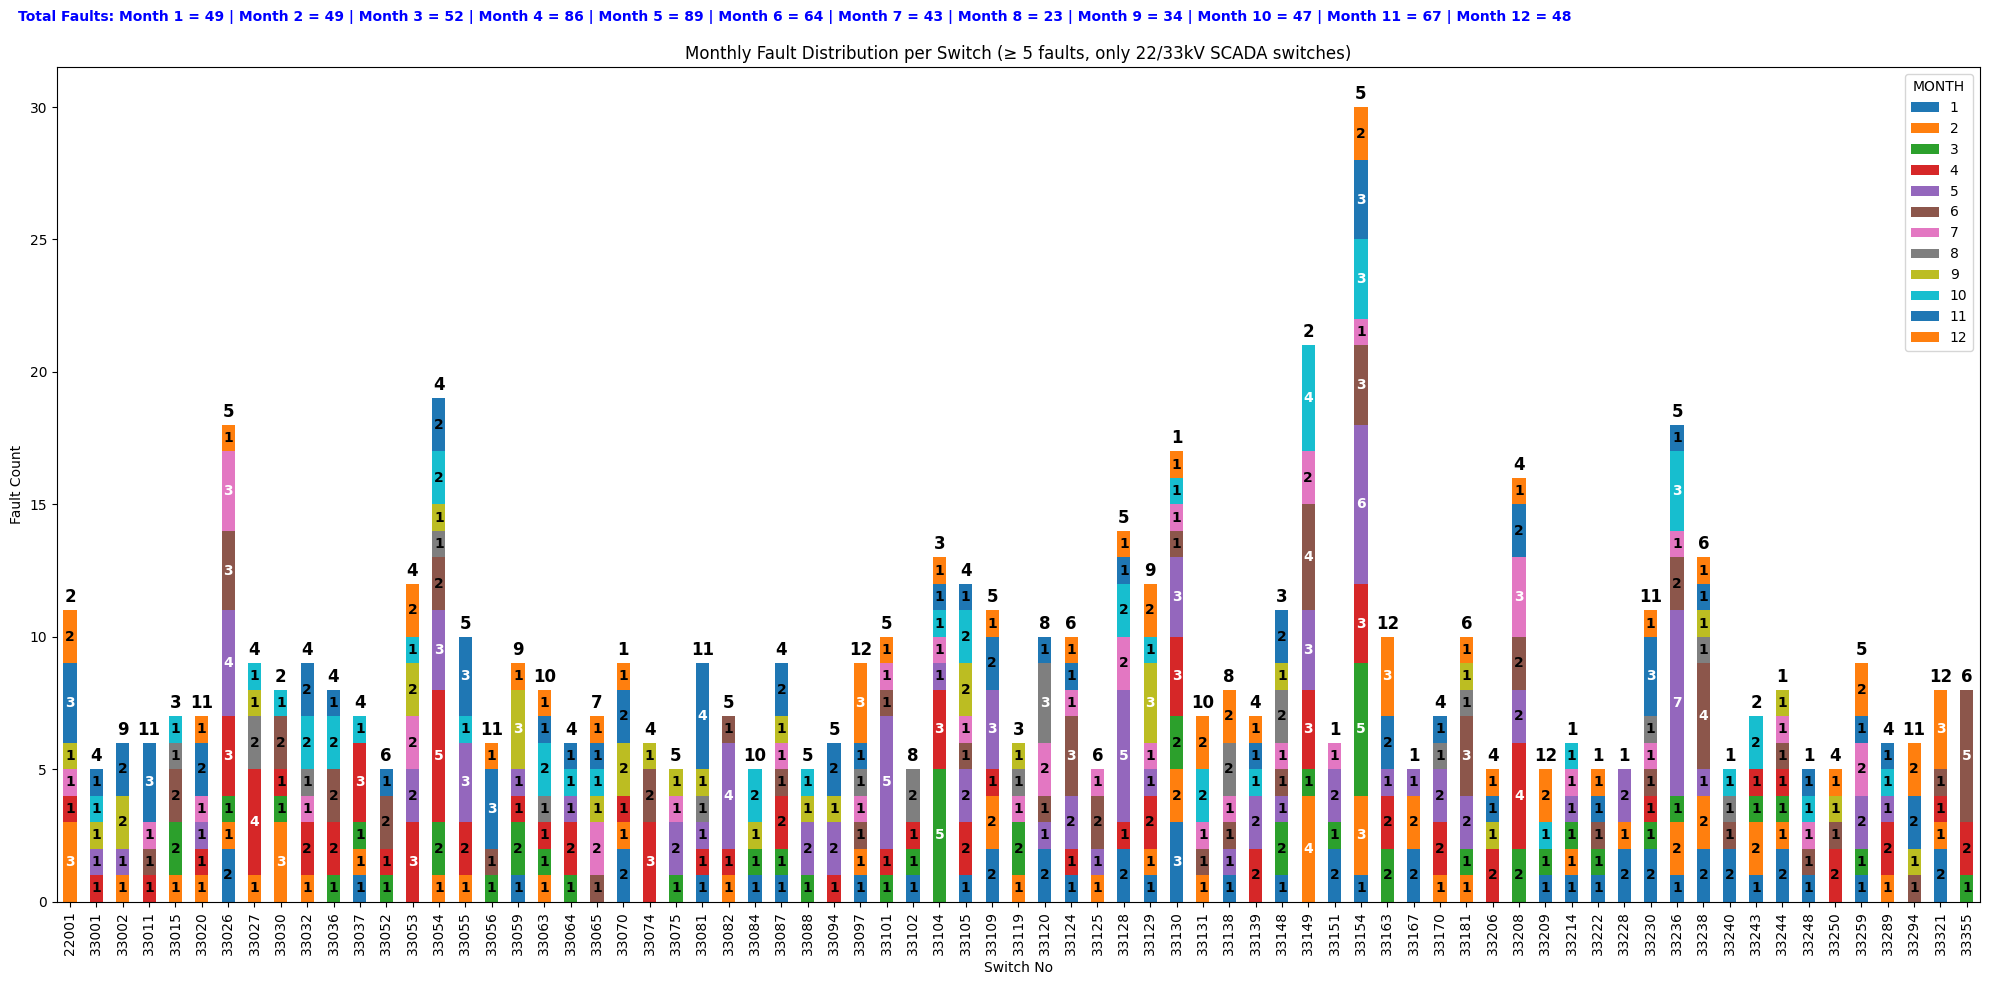

In [9]:
valid_swnos = set(scada['SWNO'].unique())
fault_filtered = fault[fault['TO_SWITCH'].isin(valid_swnos)]
# Extract month number (if needed)
fault_filtered['MONTH'] = fault_filtered['TIME_OUTAGE'].dt.month

# Group by switch and month
grouped = fault_filtered.groupby(['TO_SWITCH', 'MONTH']).size().unstack(fill_value=0)
switch_totals = grouped.sum(axis=1)
threshold = 5  # or any threshold you like

filtered = grouped[switch_totals >= threshold]
min_date = fault_filtered['TIME_OUTAGE'].min()
max_date = fault_filtered['TIME_OUTAGE'].max()
print(f"Min fault date: {min_date:%Y-%m-%d %H:%M:%S}")
print(f"Max fault date: {max_date:%Y-%m-%d %H:%M:%S}")

ax = filtered.plot(kind='bar', stacked=True, figsize=(20, 10))
plt.title("Monthly Fault Distribution per Switch (≥ {} faults, only 22/33kV SCADA switches)".format(threshold))
plt.ylabel("Fault Count")
plt.xlabel("Switch No")

# Annotate each segment
for i, (switch, row) in enumerate(filtered.iterrows()):
    bottom = 0
    for month in filtered.columns:
        count = row[month]
        if count > 0:
            ax.annotate(
                str(count),
                xy=(i, bottom + count / 2),
                ha='center',
                va='center',
                fontsize=10,
                color='white' if count > 2 else 'black',
                fontweight='bold'
            )
        bottom += count

# Annotate the highest month number for each bar
for i, (switch, row) in enumerate(filtered.iterrows()):
    if row.sum() > 0:
        max_month = row.idxmax()
        total_height = row.sum()
        ax.annotate(
            str(max_month),
            xy=(i, total_height),
            xytext=(0, 3),
            textcoords='offset points',
            ha='center', va='bottom',
            fontsize=12, color='black', fontweight='bold'
        )

# Calculate and display total faults for each month at the top
month_totals = filtered.sum(axis=0)
month_totals_str = " | ".join([f"Month {m} = {v}" for m, v in month_totals.items()])
plt.gcf().text(0.4, 0.98, "Total Faults: " + month_totals_str, fontsize=10, ha='center', va='top', color='blue', fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


/tmp/ipykernel_11407/2876481347.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  fault_filtered['MONTH'] = fault_filtered['TIME_OUTAGE'].dt.to_period('M')


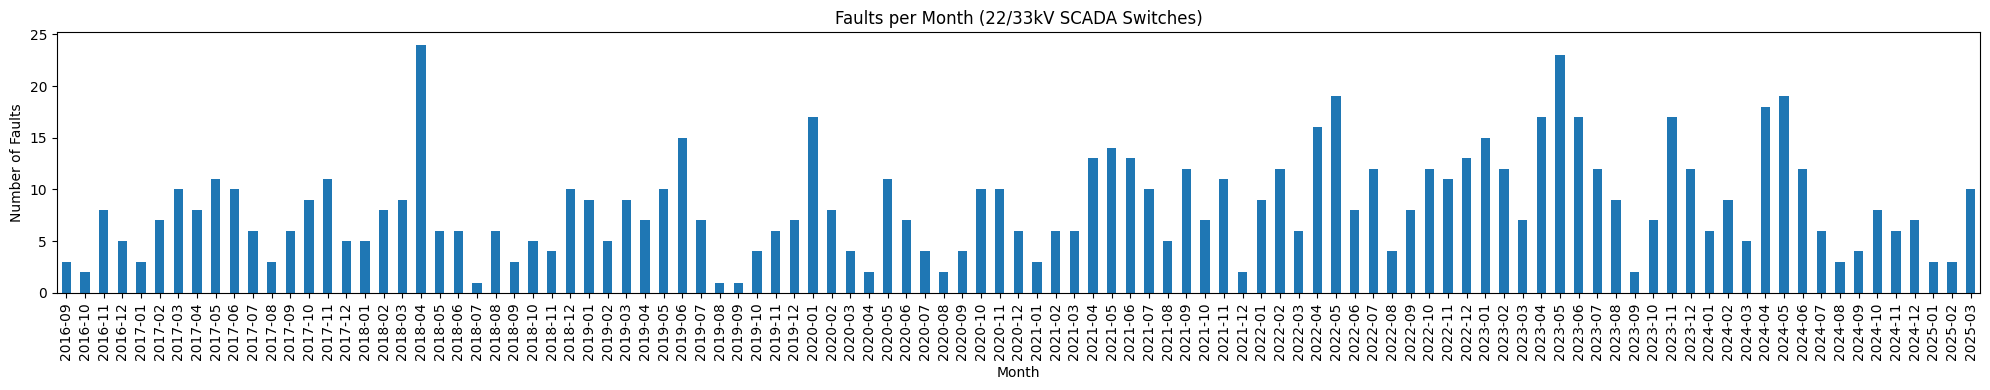

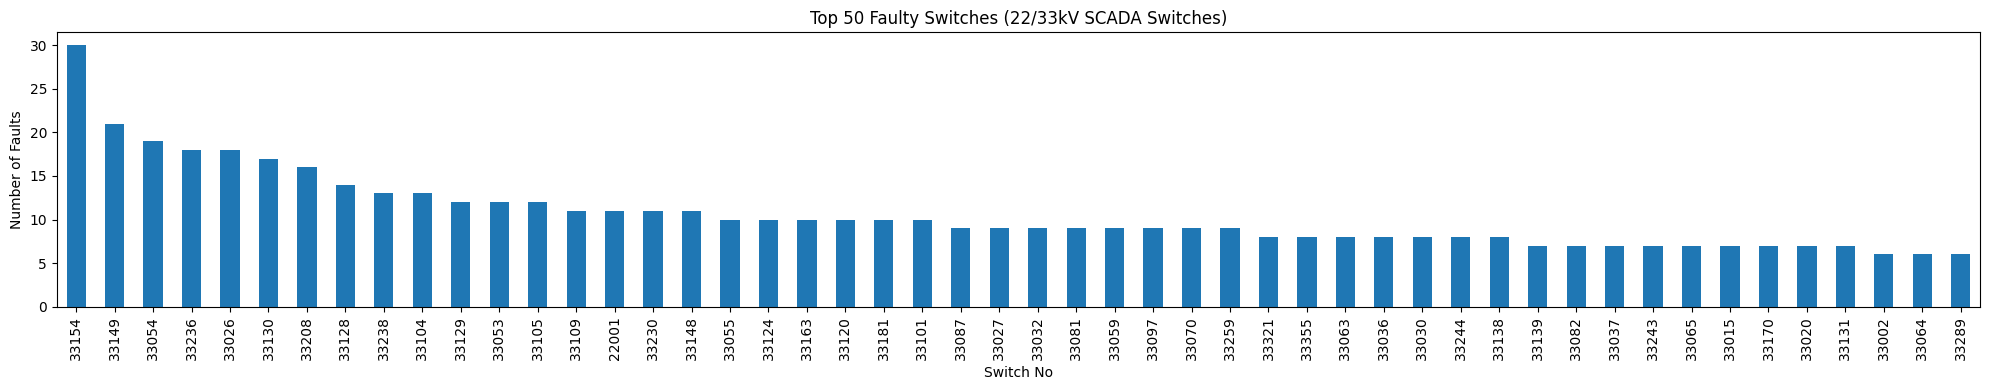

In [73]:
valid_swnos = set(scada['SWNO'].unique())
fault_filtered = fault[fault['TO_SWITCH'].isin(valid_swnos)].copy()
# Ensure TIME_OUTAGE is datetime
fault_filtered['MONTH'] = fault_filtered['TIME_OUTAGE'].dt.to_period('M')
faults_per_month = fault_filtered.groupby('MONTH').size()

faults_per_month.plot(kind='bar', figsize=(20,4), title='Faults per Month (22/33kV SCADA Switches)')
plt.ylabel("Number of Faults")
plt.xlabel("Month")
plt.tight_layout()
plt.show()
faults_per_switch = fault_filtered['TO_SWITCH'].value_counts()
N = 50  # or 10, or any N you want

faults_per_switch.head(N).plot(
    kind='bar',
    figsize=(20,4),
    title=f'Top {N} Faulty Switches (22/33kV SCADA Switches)'
)
plt.ylabel("Number of Faults")
plt.xlabel("Switch No")
plt.tight_layout()
plt.show()


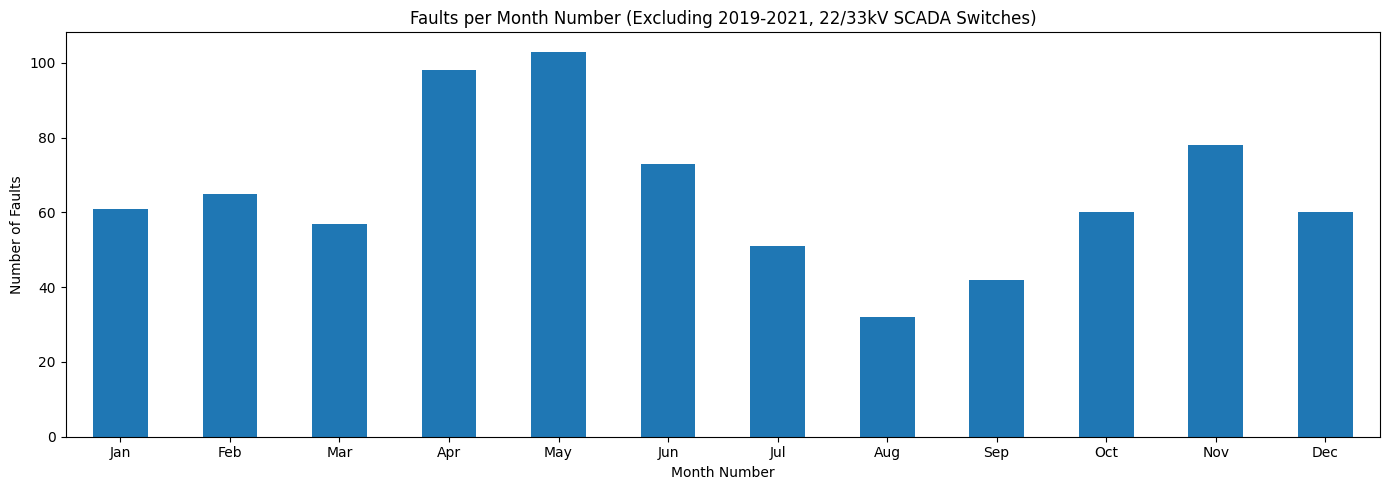

In [ ]:
import matplotlib.pyplot as plt

# Remove COVID (and pre-COVID) years: 2019, 2020, 2021
exclude_years = [2019, 2020, 2021]
fault_filtered_noncovid = fault_filtered[~fault_filtered['TIME_OUTAGE'].dt.year.isin(exclude_years)]

# Assign month number without warning
fault_filtered_noncovid = fault_filtered_noncovid.assign(
    MONTH_NUM = fault_filtered_noncovid['TIME_OUTAGE'].dt.month
)

# Count faults per month number (aggregate over all remaining years)
faults_by_monthnum = fault_filtered_noncovid['MONTH_NUM'].value_counts().sort_index()

faults_by_monthnum.plot(
    kind='bar',
    figsize=(14,5),
    title='Faults per Month Number (Excluding 2019-2021, 22/33kV SCADA Switches)'
)
plt.ylabel("Number of Faults")
plt.xlabel("Month Number")
plt.xticks(ticks=range(0,12), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation=0)
plt.tight_layout()
plt.show()


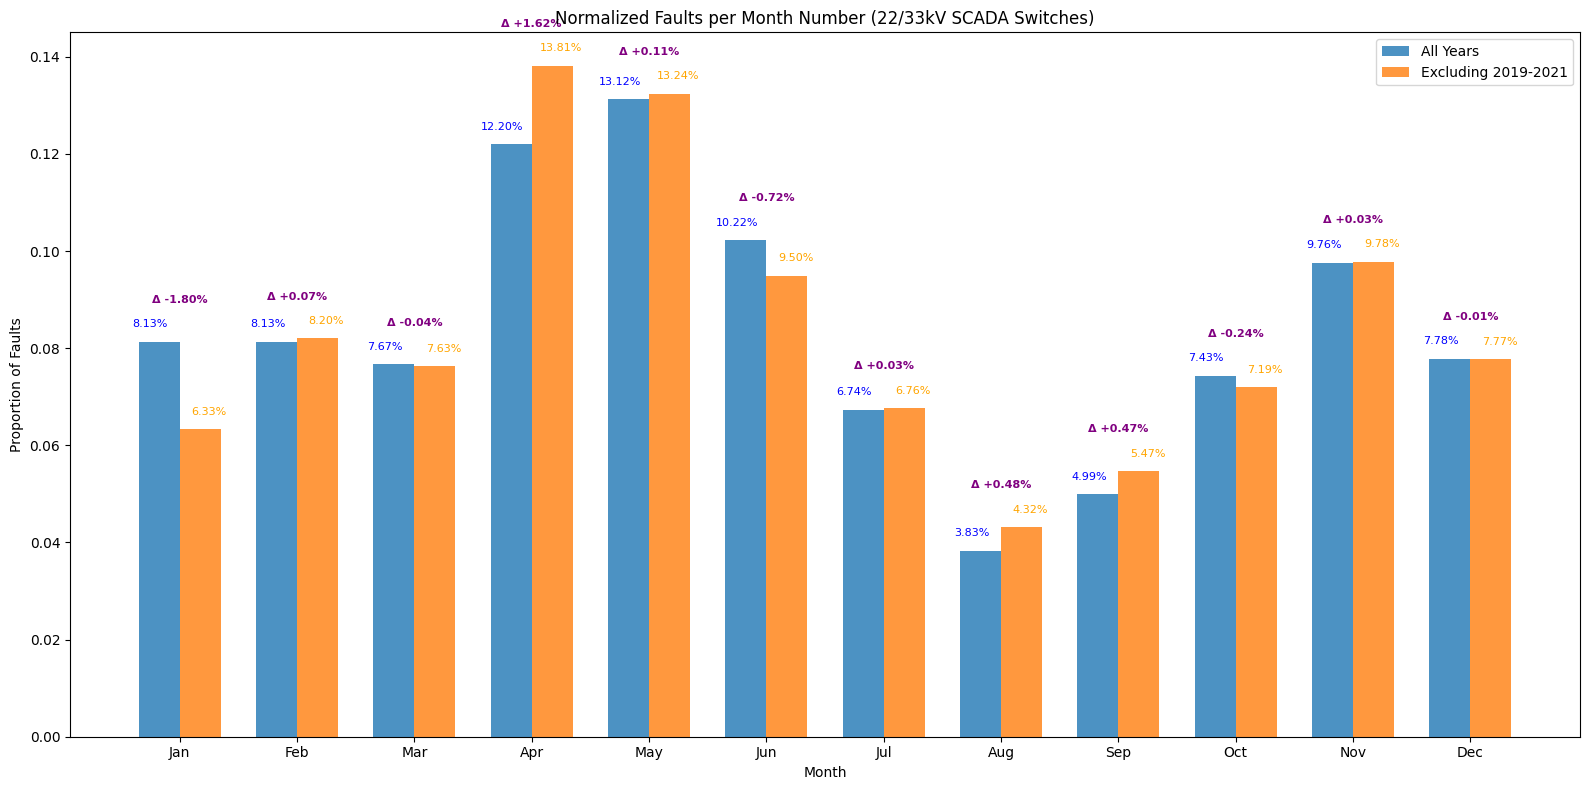

In [26]:
import matplotlib.pyplot as plt

# All years (no exclusion)
fault_filtered_all = fault_filtered.assign(
    MONTH_NUM = fault_filtered['TIME_OUTAGE'].dt.month
)
faults_by_monthnum_all = fault_filtered_all['MONTH_NUM'].value_counts().sort_index()
norm_all = faults_by_monthnum_all / faults_by_monthnum_all.sum()

# Excluding 2019, 2020, 2021
exclude_years = [2019, 2020]
fault_filtered_noncovid = fault_filtered[~fault_filtered['TIME_OUTAGE'].dt.year.isin(exclude_years)]
fault_filtered_noncovid = fault_filtered_noncovid.assign(
    MONTH_NUM = fault_filtered_noncovid['TIME_OUTAGE'].dt.month
)
faults_by_monthnum_noncovid = fault_filtered_noncovid['MONTH_NUM'].value_counts().sort_index()
norm_noncovid = faults_by_monthnum_noncovid / faults_by_monthnum_noncovid.sum()

# Plot normalized distributions
fig, ax = plt.subplots(figsize=(16,8))
width = 0.35
months = range(1, 13)
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

ax.bar(
    [m - width/2 for m in months], norm_all.values, width=width, label='All Years', color='tab:blue', alpha=0.8
)
ax.bar(
    [m + width/2 for m in months], norm_noncovid.values, width=width, label='Excluding 2019-2021', color='tab:orange', alpha=0.8
)
for i, (a, b) in enumerate(zip(norm_all.values, norm_noncovid.values), 1):
    plt.text(i - 0.25, a + 0.003, f"{a:.2%}", ha='center', fontsize=8, color='blue')
    plt.text(i + 0.25, b + 0.003, f"{b:.2%}", ha='center', fontsize=8, color='orange')

    diff = b - a
    plt.text(i, max(a, b) + 0.008, f"Δ {diff:+.2%}", ha='center', fontsize=8, color='purple', fontweight='bold')

ax.set_xticks(months)
ax.set_xticklabels(month_labels, rotation=0)
ax.set_ylabel("Proportion of Faults")
ax.set_xlabel("Month")
ax.set_title("Normalized Faults per Month Number (22/33kV SCADA Switches)")
ax.legend()
plt.tight_layout()
plt.show()


ML ALGORITHM 

In [77]:
import pandas as pd


from joblib import Parallel, delayed
import pandas as pd
from pathlib import Path

USEFUL_COLUMNS = ['VOLTAGE', 'SWNO', 'SYSTIME', 'PARA', 'VALUE']

def process_file(f):
    cols = [col for col in USEFUL_COLUMNS if col in pd.read_csv(f, nrows=1).columns]
    df = pd.read_csv(f, usecols=cols)
    df['PARA'] = df['PARA'].astype(str).str.upper()
    df['VOLTAGE'] = df['VOLTAGE'].astype(str).str.upper().str.replace(' ', '')
    df = df[df['PARA'] == 'I']
    df = df[df['VOLTAGE'].str.contains('22|22KV|33|33KV', na=False)]
    df['SYSTIME'] = pd.to_datetime(df['SYSTIME'], errors='coerce')
    df['SWNO'] = df['SWNO'].astype(str)
    return df

files = [f for folder in SCADA_FOLDERS for f in folder.glob("*.csv")]

scada_dfs = Parallel(n_jobs=10)(delayed(process_file)(f) for f in files)
scada = pd.concat(scada_dfs, ignore_index=True)

/tmp/ipykernel_138255/2762620075.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_138255/2762620075.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_138255/2762620075.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_138255/2762620075.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_138255/2762620075.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_138255/2762620075.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_138255/2762620075.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
/tmp/ipykernel_13825

In [79]:
# Load Fault Data
fault = pd.read_csv(FAULT_CSV)
fault['TIME_OUTAGE'] = pd.to_datetime(fault['TIME_OUTAGE'], errors='coerce')
fault['TO_SWITCH'] = fault['TO_SWITCH'].astype(str)

# Create key set for fast lookup
# Ensure datetime
scada['SYSTIME'] = pd.to_datetime(scada['SYSTIME'], errors='coerce')
# Drop rows with invalid SYSTIME
scada = scada[scada['SYSTIME'].notnull()]
# Extract date
scada['DATE'] = scada['SYSTIME'].dt.date

scada_key_set = set(zip(scada['SWNO'], scada['DATE']))

def has_scada_data_fast(row):
    return (row['TO_SWITCH'], row['TIME_OUTAGE'].date()) in scada_key_set

from joblib import Parallel, delayed
fault['has_scada_on_date'] = Parallel(n_jobs=10)(
    delayed(has_scada_data_fast)(row)
    for _, row in fault.iterrows()
)


In [81]:
common_switches = set(scada['SWNO'].unique()) & set(fault['TO_SWITCH'].unique())
print(f"Number of switches with both SCADA and Fault data: {len(common_switches)}")


Number of switches with both SCADA and Fault data: 182


In [82]:
fault_with_scada = fault[fault['TO_SWITCH'].isin(common_switches)].copy()
fault_with_scada['DATE'] = fault_with_scada['TIME_OUTAGE'].dt.date

In [83]:

fault_with_scada['has_scada_on_date'] = fault_with_scada.apply(has_scada_data, axis=1)
print(fault_with_scada[['TO_SWITCH', 'TIME_OUTAGE', 'has_scada_on_date']].head())

coverage_pct = fault_with_scada['has_scada_on_date'].mean()
print(f"\nFraction of faults with same-day SCADA data: {coverage_pct:.2%}")

NameError: name 'has_scada_data' is not defined

In [80]:
scada['YEAR'] = scada['SYSTIME'].dt.year
scada['MONTH'] = scada['SYSTIME'].dt.month
range_df = (
    scada.groupby('SWNO')
    .agg(
        min_date=('SYSTIME', 'min'),
        max_date=('SYSTIME', 'max'),
        years=('YEAR', lambda x: sorted(x.unique())),
        months=('MONTH', lambda x: sorted(x.unique()))
    )
    .reset_index()
)


In [89]:
print(fault_with_scada[['TO_SWITCH', 'TIME_OUTAGE', 'has_scada_on_date']].head())


    TO_SWITCH               TIME_OUTAGE  has_scada_on_date
219     33140 2020-10-12 14:44:37+00:00              False
220     33139 2020-04-16 18:06:00+00:00              False
221     33139 2020-05-29 11:32:16+00:00              False
222     33015 2020-10-16 15:23:00+00:00              False
223     33159 2020-07-03 19:09:00+00:00              False


In [88]:
coverage_pct = fault_with_scada['has_scada_on_date'].mean()
print(f"\nFraction of faults with same-day SCADA data: {coverage_pct:.2%}")


Fraction of faults with same-day SCADA data: 12.87%


In [86]:
print(range_df.head(10))
range_df.to_csv("scada_date_ranges.csv", index=False)

   SWNO                  min_date                  max_date         years  \
0  1102 2024-01-01 00:00:00+00:00 2025-04-02 23:45:00+00:00  [2024, 2025]   
1  1103 2024-01-01 00:00:00+00:00 2025-04-02 23:45:00+00:00  [2024, 2025]   
2  1128 2024-01-01 00:00:00+00:00 2025-04-02 23:45:00+00:00  [2024, 2025]   
3  1129 2024-01-01 00:00:00+00:00 2025-04-02 23:45:00+00:00  [2024, 2025]   
4  1133 2024-01-01 00:00:00+00:00 2025-04-02 23:45:00+00:00  [2024, 2025]   
5  1135 2024-01-01 00:00:00+00:00 2025-04-02 23:45:00+00:00  [2024, 2025]   
6  1143 2024-01-01 00:00:00+00:00 2025-04-02 23:45:00+00:00  [2024, 2025]   
7  1151 2024-01-01 00:00:00+00:00 2025-04-02 23:45:00+00:00  [2024, 2025]   
8  1159 2024-01-01 00:00:00+00:00 2025-04-02 23:45:00+00:00  [2024, 2025]   
9  1163 2024-01-01 00:00:00+00:00 2025-04-02 23:45:00+00:00  [2024, 2025]   

                                    months  
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  
2  [1, 2, 3, 4, 5

In [ ]:
import pandas as pd
from pathlib import Path
from joblib import Parallel, delayed

# ---- Load Cable Data (filter REMARKS, VOLTAGE) ----

cable = pd.read_csv(CABLE_META)
# Remove "abandoned" or "disconnected"
cable = cable[~cable['REMARKS'].str.upper().isin(['ABANDONED', 'DISCONNECTED'])]
# Keep only VOLTAGE 22/33

USEFUL_COLUMNS = ['VOLTAGE', 'SWNO', 'SYSTIME', 'PARA', 'VALUE']

def process_file(f):
    cols = [col for col in USEFUL_COLUMNS if col in pd.read_csv(f, nrows=1).columns]
    df = pd.read_csv(f, usecols=cols, low_memory=False)
    df['PARA'] = df['PARA'].astype(str).str.upper()
    df['VOLTAGE'] = df['VOLTAGE'].astype(str).str.upper().str.replace(' ', '')
    df = df[df['PARA'] == 'I']
    df = df[df['VOLTAGE'].str.contains('22|22KV|33|33KV', na=False)]
    df['SYSTIME'] = pd.to_datetime(df['SYSTIME'], errors='coerce')
    df['SWNO'] = df['SWNO'].astype(str)
    return df

files = [f for folder in SCADA_FOLDERS for f in folder.glob("*.csv")]
scada_dfs = Parallel(n_jobs=10)(delayed(process_file)(f) for f in files)
scada = pd.concat(scada_dfs, ignore_index=True)
scada = scada[scada['SYSTIME'].notnull()]  # keep only valid datetimes


fault = pd.read_csv(FAULT_CSV, low_memory=False)
fault['VOLTAGE'] = fault['VOLTAGE'].astype(str).str.upper().str.replace(' ', '')
fault = fault[fault['VOLTAGE'].str.contains('22|22KV|33|33KV', na=False)]
# Ensure TIME_OUTAGE is datetime
fault['TIME_OUTAGE'] = pd.to_datetime(fault['TIME_OUTAGE'], errors='coerce')
fault['TO_SWITCH'] = fault['TO_SWITCH'].astype(str)

# ---- Filter Faults to Only Cables in 22/33kV ----
valid_switches = set(cable['DESTINATION_SWITCH_ID'].astype(str))
fault = fault[fault['TO_SWITCH'].isin(valid_switches)]
scada['SYSTIME'] = pd.to_datetime(scada['SYSTIME'], errors='coerce')

# ---- Create lookup set for fast SCADA date matching ----
scada['DATE'] = scada['SYSTIME'].dt.date
scada_key_set = set(zip(scada['SWNO'], scada['DATE']))

def has_scada_data_fast(row):
    try:
        return (row['TO_SWITCH'], row['TIME_OUTAGE'].date()) in scada_key_set
    except Exception:
        return False  # for any bad row

# Parallel check for all faults
fault['has_scada_on_date'] = Parallel(n_jobs=10)(
    delayed(has_scada_data_fast)(row)
    for _, row in fault.iterrows()
)

coverage_pct = fault['has_scada_on_date'].mean()
print(f"\nFraction of filtered faults with same-day SCADA data: {coverage_pct:.2%}")

# ---- SCADA Data Range per Switch (just for reference/reporting) ----
scada['YEAR'] = scada['SYSTIME'].dt.year
scada['MONTH'] = scada['SYSTIME'].dt.month
range_df = (
    scada.groupby('SWNO')
    .agg(
        min_date=('SYSTIME', 'min'),
        max_date=('SYSTIME', 'max'),
        years=('YEAR', lambda x: sorted(x.unique())),
        months=('MONTH', lambda x: sorted(x.unique()))
    )
    .reset_index()
)
print(range_df.head(10))


/tmp/ipykernel_859706/111408800.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



Fraction of filtered faults with same-day SCADA data: 13.79%
   SWNO                  min_date                  max_date         years  \
0  1102 2024-01-01 00:00:00+00:00 2025-04-02 23:45:00+00:00  [2024, 2025]   
1  1103 2024-01-01 00:00:00+00:00 2025-04-02 23:45:00+00:00  [2024, 2025]   
2  1128 2024-01-01 00:00:00+00:00 2025-04-02 23:45:00+00:00  [2024, 2025]   
3  1129 2024-01-01 00:00:00+00:00 2025-04-02 23:45:00+00:00  [2024, 2025]   
4  1133 2024-01-01 00:00:00+00:00 2025-04-02 23:45:00+00:00  [2024, 2025]   
5  1135 2024-01-01 00:00:00+00:00 2025-04-02 23:45:00+00:00  [2024, 2025]   
6  1143 2024-01-01 00:00:00+00:00 2025-04-02 23:45:00+00:00  [2024, 2025]   
7  1151 2024-01-01 00:00:00+00:00 2025-04-02 23:45:00+00:00  [2024, 2025]   
8  1159 2024-01-01 00:00:00+00:00 2025-04-02 23:45:00+00:00  [2024, 2025]   
9  1163 2024-01-01 00:00:00+00:00 2025-04-02 23:45:00+00:00  [2024, 2025]   

                                    months  
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  


In [ ]:
import pandas as pd
from joblib import Parallel, delayed
USEFUL_COLUMNS = ['VOLTAGE', 'SWNO', 'SYSTIME', 'PARA', 'VALUE']

def process_file(f):
    cols = [col for col in USEFUL_COLUMNS if col in pd.read_csv(f, nrows=1).columns]
    df = pd.read_csv(f, usecols=cols, low_memory=False)
    df['PARA'] = df['PARA'].astype(str).str.upper()
    df['VOLTAGE'] = df['VOLTAGE'].astype(str).str.upper().str.replace(' ', '')
    df = df[df['PARA'] == 'I']
    df = df[df['VOLTAGE'].str.contains('22|22KV|33|33KV', na=False)]
    df['SYSTIME'] = pd.to_datetime(df['SYSTIME'], errors='coerce')
    df['SWNO'] = df['SWNO'].astype(str)
    return df

files = [f for folder in SCADA_FOLDERS for f in folder.glob("*.csv")]
scada_dfs = Parallel(n_jobs=10)(delayed(process_file)(f) for f in files)
scada = pd.concat(scada_dfs, ignore_index=True)
scada = scada[scada['SYSTIME'].notnull()]  # keep only valid datetimes


/tmp/ipykernel_1053552/101973008.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


KeyError: 'DAY'

In [7]:
cable = pd.read_csv(CABLE_META)
# --- Step 2: Define cycle count function ---
def count_cycles(series, mult=1.8):
    median = series.median()
    return ((series > median * mult) | (series < median / mult)).sum()


scada['SYSTIME'] = pd.to_datetime(scada['SYSTIME'], errors='coerce')
scada['DAY'] = scada['SYSTIME'].dt.normalize()
# --- Step 3: Aggregate daily features for each switch ---
daily_features = (
    scada.groupby(['SWNO', 'DAY'])
    .agg(
        mean_load=('VALUE', 'mean'),
        std_load=('VALUE', 'std'),
        min_load=('VALUE', 'min'),
        max_load=('VALUE', 'max'),
        range_load=('VALUE', lambda x: x.max() - x.min()),
        cycle_count=('VALUE', count_cycles),
        readings=('VALUE', 'count'),
    )
    .reset_index()
)


# Step 4: Compute cable installation date (INSTALL_DATE)
cable['INSTALL_DATE'] = pd.to_datetime(cable['DATECREATED'], errors='coerce')

# Fix: Remove timezone information if present
cable['INSTALL_DATE'] = cable['INSTALL_DATE'].dt.tz_localize(None)

# Ensure matching types
cable['DESTINATION_SWITCH_ID'] = cable['DESTINATION_SWITCH_ID'].astype(str)
daily_features['SWNO'] = daily_features['SWNO'].astype(str)

# Step 4: Compute cable installation date (INSTALL_DATE)
cable['INSTALL_DATE'] = pd.to_datetime(cable['DATECREATED'], errors='coerce')

# Fix: Remove timezone information if present
cable['INSTALL_DATE'] = cable['INSTALL_DATE'].dt.tz_localize(None)

# Remove timezone info from both sides to make them tz-naive
install_dates = cable.set_index('DESTINATION_SWITCH_ID')['INSTALL_DATE'].dt.tz_localize(None)
sw_to_install = install_dates.to_dict()

daily_features['cable_age_days'] = daily_features.apply(
    lambda row: (
        (row['DAY'].tz_localize(None) - sw_to_install.get(row['SWNO']))
        .days if pd.notnull(sw_to_install.get(row['SWNO'])) else None
    ),
    axis=1
)

# Recalculate cable_age_days

# Reattach cabletype and no_of_segment after type fixing
for col in ['CABLETYPE', 'NO_OF_SEGMENT']:
    daily_features[col.lower()] = daily_features['SWNO'].map(cable.set_index('DESTINATION_SWITCH_ID')[col].to_dict())

print(daily_features.head())


/home/sagark24/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/sagark24/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/sagark24/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/sagark24/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/sagark24/miniconda3/envs/py310/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/sagark24/

   SWNO                       DAY  mean_load   std_load   min_load  \
0  1102 2024-01-01 00:00:00+00:00  89.717767  10.467650  68.135864   
1  1102 2024-01-02 00:00:00+00:00  92.834977  12.834457  64.062363   
2  1102 2024-01-03 00:00:00+00:00  90.993919  14.064084  61.703560   
3  1102 2024-01-04 00:00:00+00:00  91.699108  13.330357  62.487930   
4  1102 2024-01-05 00:00:00+00:00  87.881220  14.069433  59.298847   

     max_load  range_load  cycle_count  readings  cable_age_days cabletype  \
0  109.241364   41.105499            0       166           579.0      XLPE   
1  112.780754   48.718391            0       177           580.0      XLPE   
2  114.146774   52.443214            0       188           581.0      XLPE   
3  113.719833   51.231903            0       178           582.0      XLPE   
4  112.319626   53.020779            0       170           583.0      XLPE   

   no_of_segment  
0           20.0  
1           20.0  
2           20.0  
3           20.0  
4           20.

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
fault = pd.read_csv(FAULT_CSV, parse_dates=['TIME_OUTAGE'])
os.makedirs("fault_plots_cycle2", exist_ok=True)
os.makedirs("fault_plots_cycle_missing", exist_ok=True)
all_switches = daily_features['SWNO'].unique()
for switch_id in all_switches:
    faults_for_switch = fault[fault['TO_SWITCH'] == switch_id].copy()
    if faults_for_switch.empty:
        continue
    faults_for_switch['FAULT_YEAR'] = faults_for_switch['TIME_OUTAGE'].dt.year
    faults_for_switch['FAULT_MONTH_NUM'] = faults_for_switch['TIME_OUTAGE'].dt.month

    # --- Add: SCADA months available for this switch ---
    scada_months = daily_features[daily_features['SWNO'] == switch_id].copy()
    scada_months['YEAR'] = scada_months['DAY'].dt.year
    scada_months['MONTH'] = scada_months['DAY'].dt.month
    available_months = set(zip(scada_months['YEAR'], scada_months['MONTH']))

    for (target_year, target_month) in faults_for_switch[['FAULT_YEAR', 'FAULT_MONTH_NUM']].drop_duplicates().itertuples(index=False):
        if (target_year, target_month) not in available_months:
            continue

        daily_data = daily_features[
            (daily_features['SWNO'] == switch_id) &
            (daily_features['DAY'].dt.year == target_year) &
            (daily_features['DAY'].dt.month == target_month)
        ].copy()
        if daily_data.empty:
            continue

        fault_days = faults_for_switch[
            (faults_for_switch['FAULT_YEAR'] == target_year) &
            (faults_for_switch['FAULT_MONTH_NUM'] == target_month)
        ]['TIME_OUTAGE'].dt.normalize().unique()

        mean_cycle = daily_data['cycle_count'].mean()
        median_cycle = daily_data['cycle_count'].median()

        fault_with_load = []
        fault_missing_load = []
        for fault_day in fault_days:
            if not daily_data[daily_data['DAY'] == fault_day].empty:
                fault_with_load.append(fault_day)
            else:
                fault_missing_load.append(fault_day)

        plt.figure(figsize=(14, 8))
        plt.plot(daily_data['DAY'], daily_data['cycle_count'], label='Cycle Count', marker='o')
        plt.plot(daily_data['DAY'], daily_data['std_load'], label='Load Std', linestyle='--', marker='x', color='orange')
        plt.plot(daily_data['DAY'], daily_data['range_load'], label='Load Range', linestyle=':', color='green')
        plt.plot(daily_data['DAY'], daily_data['mean_load'], label='Mean Load', linestyle='-', color='grey', alpha=0.6)

        threshold = daily_data['cycle_count'].quantile(0.9)
        high_cycle_days = daily_data[daily_data['cycle_count'] >= threshold]
        plt.scatter(high_cycle_days['DAY'], high_cycle_days['cycle_count'], color='purple', s=70, marker='D', label='High Cycle Day')

        # --- Annotate fault dates above red dots ---
        for fault_day in fault_with_load:
            day_point = daily_data[daily_data['DAY'] == fault_day]
            if not day_point.empty:
                plt.scatter(day_point['DAY'], day_point['cycle_count'], color='red', s=120, label='Fault' if 'Fault' not in plt.gca().get_legend_handles_labels()[1] else "")
                # Annotate the fault date (above the red dot)
                for x, y in zip(day_point['DAY'], day_point['cycle_count']):
                    # Convert date to string (day/month)
                    fault_date_str = pd.to_datetime(x).strftime("%Y-%m-%d")
                    plt.annotate(fault_date_str, (x, y), textcoords="offset points", xytext=(0,10), ha='center', color='red', fontsize=9, fontweight='bold')

        # Faults MISSING data (black X at mean_cycle)
        for fault_day in fault_missing_load:
            plt.scatter(fault_day, mean_cycle, color='black', marker='x', s=120, label='Fault (No Load, Used Mean)' if 'Fault (No Load, Used Mean)' not in plt.gca().get_legend_handles_labels()[1] else "")

        # Cable info
        if not daily_data.empty:
            cabletype = daily_data['cabletype'].iloc[0] if 'cabletype' in daily_data.columns else 'NA'
            nseg = daily_data['no_of_segment'].iloc[0] if 'no_of_segment' in daily_data.columns else 'NA'
            arm = daily_data['armoured'].iloc[0] if 'armoured' in daily_data.columns else 'NA'
            age = int(daily_data['cable_age_days'].iloc[0]) if 'cable_age_days' in daily_data.columns and pd.notnull(daily_data['cable_age_days'].iloc[0]) else 'NA'
        else:
            cabletype = nseg = arm = age = 'NA'

        plt.axhline(mean_cycle, linestyle='--', color='blue', alpha=0.2, label=f'Mean Cycle ({mean_cycle:.1f})')
        plt.axhline(median_cycle, linestyle='-.', color='red', alpha=0.2, label=f'Median Cycle ({median_cycle:.1f})')

        plt.title(f"Switch {switch_id} {target_year}-{target_month:02d}\nType:{cabletype}, Segments:{nseg}, Armoured:{arm}, Age:{age} days")
        plt.xlabel("Day")
        plt.ylabel("Value")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"fault_plots_cycle2/cycle_trend_{switch_id}_{target_year}-{target_month:02d}.png")
        plt.close()

        # --- Plot for missing load days, as before ---
        if fault_missing_load:
            plt.figure(figsize=(14, 8))
            plt.plot(daily_data['DAY'], daily_data['cycle_count'], label='Cycle Count', marker='o')
            for fault_day in fault_missing_load:
                plt.scatter(fault_day, mean_cycle, color='black', marker='x', s=120, label='Fault (No Load, Used Mean)' if 'Fault (No Load, Used Mean)' not in plt.gca().get_legend_handles_labels()[1] else "")
                # Annotate the fault date above black X
                fault_date_str = pd.to_datetime(fault_day).strftime("%Y-%m-%d")
                plt.annotate(fault_date_str, (fault_day, mean_cycle), textcoords="offset points", xytext=(0,10), ha='center', color='black', fontsize=9, fontweight='bold')
            plt.title(f"[MISSING LOAD] Switch {switch_id} {target_year}-{target_month:02d}")
            plt.xlabel("Day")
            plt.ylabel("Cycle Count")
            plt.axhline(mean_cycle, linestyle='--', color='blue', alpha=0.2, label=f'Mean Cycle ({mean_cycle:.1f})')
            plt.axhline(median_cycle, linestyle='-.', color='red', alpha=0.2, label=f'Median Cycle ({median_cycle:.1f})')
            plt.legend()
            plt.tight_layout()
            plt.savefig(f"fault_plots_cycle_missing/cycle_trend_{switch_id}_{target_year}-{target_month:02d}.png")
            plt.close()


MISSIING vALUES USING THE MEAN OF ALL THE DAY AND MINTUeS

In [ ]:
import pandas as pd

# Assume daily_features has: SWNO, DAY (datetime), cycle_count, mean_load, etc.

daily_features['DAY_OF_MONTH'] = daily_features['DAY'].dt.day
daily_features['MONTH'] = daily_features['DAY'].dt.month

# Group by SWNO, MONTH, DAY_OF_MONTH (across years!)
daily_monthly_profile = (
    daily_features
    .groupby(['SWNO', 'MONTH', 'DAY_OF_MONTH'])
    .agg(
        mean_cycle_count=('cycle_count', 'mean'),
        std_cycle_count=('cycle_count', 'std'),
        mean_load=('mean_load', 'mean'),
        std_load=('mean_load', 'std')
    )
    .reset_index()
)


In [10]:
import pandas as pd
import numpy as np

# Make sure SYSTIME is datetime
scada['SYSTIME'] = pd.to_datetime(scada['SYSTIME'], errors='coerce')
scada['MONTH'] = scada['SYSTIME'].dt.month
scada['DAY_OF_MONTH'] = scada['SYSTIME'].dt.day
scada['MINUTE_OF_DAY'] = scada['SYSTIME'].dt.hour * 60 + scada['SYSTIME'].dt.minute

# Optional: also add 'year' if you want to separate by year
# scada['YEAR'] = scada['SYSTIME'].dt.year

# Group by switch, month, day-of-month, minute-of-day
minute_profile = (
    scada.groupby(['SWNO', 'MONTH', 'DAY_OF_MONTH', 'MINUTE_OF_DAY'])
    .agg(
        mean_value=('VALUE', 'mean'),
        std_value=('VALUE', 'std'),
        min_value=('VALUE', 'min'),
        max_value=('VALUE', 'max'),
        count=('VALUE', 'count')
    )
    .reset_index()
)

print(minute_profile.head())

# If you want a "mean minute profile" **averaged over all days of month and all years**:
mean_minute_profile = (
    scada.groupby(['SWNO', 'MONTH', 'MINUTE_OF_DAY'])
    .agg(
        mean_value=('VALUE', 'mean'),
        std_value=('VALUE', 'std'),
        min_value=('VALUE', 'min'),
        max_value=('VALUE', 'max'),
        count=('VALUE', 'count')
    )
    .reset_index()
)

print(mean_minute_profile.head())


   SWNO  MONTH  DAY_OF_MONTH  MINUTE_OF_DAY  mean_value  std_value  min_value  \
0  1102      1             1              0   85.849174   2.900306  83.798348   
1  1102      1             1             11   81.797577        NaN  81.797577   
2  1102      1             1             15   86.900000        NaN  86.900000   
3  1102      1             1             18   83.860100        NaN  83.860100   
4  1102      1             1             30   85.950000        NaN  85.950000   

   max_value  count  
0  87.900000      2  
1  81.797577      1  
2  86.900000      1  
3  83.860100      1  
4  85.950000      1  
   SWNO  MONTH  MINUTE_OF_DAY  mean_value  std_value  min_value   max_value  \
0  1102      1              0   84.250752  11.882911  65.515533  125.740120   
1  1102      1              3   77.194794        NaN  77.194794   77.194794   
2  1102      1              4   78.389470  11.702064  65.993927   93.862732   
3  1102      1              5   76.830463  14.293573  66.723381  

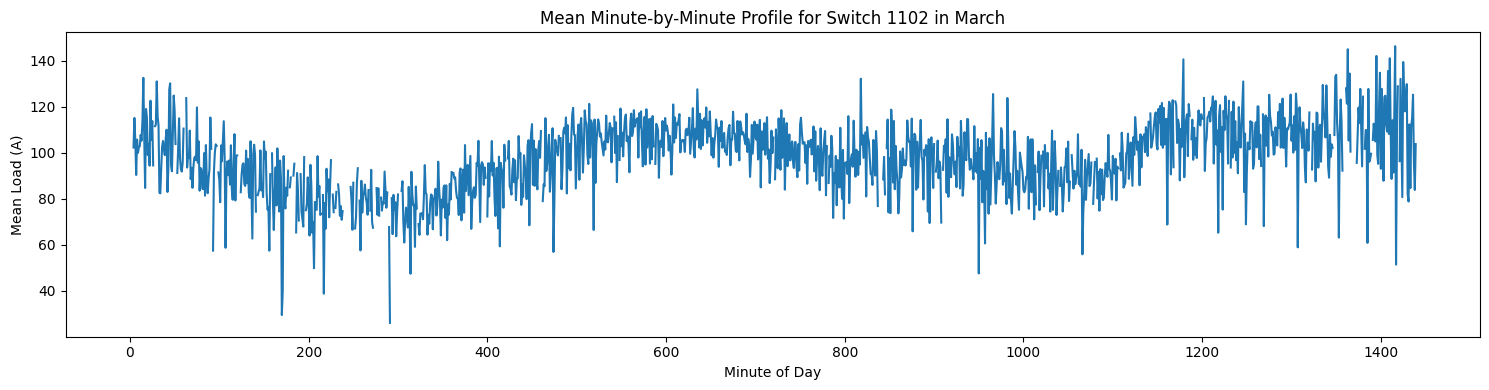

In [11]:
# Example: full profile for switch '1102' in March (MONTH=3)
profile = mean_minute_profile[
    (mean_minute_profile['SWNO'] == '1102') &
    (mean_minute_profile['MONTH'] == 3)
]

# Ensure all minutes are present for plotting
full_minutes = pd.DataFrame({'MINUTE_OF_DAY': np.arange(0, 24*60)})
profile_full = full_minutes.merge(profile, on='MINUTE_OF_DAY', how='left')
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.plot(profile_full['MINUTE_OF_DAY'], profile_full['mean_value'])
plt.xlabel("Minute of Day")
plt.ylabel("Mean Load (A)")
plt.title("Mean Minute-by-Minute Profile for Switch 1102 in March")
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
import numpy as np

# --- Step 1: Prepare minute-of-day profiles ---
scada['SYSTIME'] = pd.to_datetime(scada['SYSTIME'], errors='coerce')
scada['MONTH'] = scada['SYSTIME'].dt.month
scada['MINUTE_OF_DAY'] = scada['SYSTIME'].dt.hour * 60 + scada['SYSTIME'].dt.minute

# Mean profile for each (SWNO, MONTH, MINUTE_OF_DAY) across all years
minute_monthly_profile = (
    scada.groupby(['SWNO', 'MONTH', 'MINUTE_OF_DAY'])
    .agg(
        mean_value=('VALUE', 'mean'),
        std_value=('VALUE', 'std'),
        min_value=('VALUE', 'min'),
        max_value=('VALUE', 'max'),
        count=('VALUE', 'count')
    )
    .reset_index()
)

# --- Step 2: Aggregate minute-level profile stats by switch and month ---
profile_minute_stats = []
for (switch_id, month), group in minute_monthly_profile.groupby(['SWNO', 'MONTH']):
    min_means = group['mean_value'].values

    stat = {
        'SWNO': switch_id,
        'MONTH': month,
        'mean_of_means_minute': np.mean(min_means),
        'std_of_means_minute': np.std(min_means),
        'min_of_means_minute': np.min(min_means),
        'max_of_means_minute': np.max(min_means),
        'range_of_means_minute': np.ptp(min_means),
        'median_of_means_minute': np.median(min_means),
        'high_minute_count': (min_means > 1.5 * np.median(min_means)).sum()
    }
    profile_minute_stats.append(stat)

profile_minute_stats_df = pd.DataFrame(profile_minute_stats)
print("Minute-level monthly profile summary:")
print(profile_minute_stats_df.head())

# --- Step 3: Merge with fault data ---
fault['FAULT_MONTH'] = fault['TIME_OUTAGE'].dt.month
fault = fault.merge(profile_minute_stats_df, left_on=['TO_SWITCH', 'FAULT_MONTH'], right_on=['SWNO', 'MONTH'], how='left')

print("\nSample of merged fault data with minute profile features:")
print(fault[['TO_SWITCH', 'TIME_OUTAGE', 'mean_of_means_minute', 'std_of_means_minute', 'median_of_means_minute']].head())


Minute-level monthly profile summary:
   SWNO  MONTH  mean_of_means_minute  std_of_means_minute  \
0  1102      1             92.735134            18.345591   
1  1102      2            104.459661            19.103475   
2  1102      3             97.633525            15.500159   
3  1102      4            123.849999            16.410139   
4  1102      5            128.026005            18.705893   

   min_of_means_minute  max_of_means_minute  range_of_means_minute  \
0            46.810937           163.600494             116.789558   
1            55.761555           165.640854             109.879299   
2            26.056545           146.334518             120.277973   
3            87.457886           188.771217             101.313332   
4            87.038071           196.947830             109.909759   

   median_of_means_minute  high_minute_count  
0               94.204628                  8  
1              105.352521                 10  
2               98.713317        

In [14]:
import numpy as np
import pandas as pd

# If not done yet, extract day and month
daily_features['DAY_OF_MONTH'] = daily_features['DAY'].dt.day
daily_features['MONTH'] = daily_features['DAY'].dt.month

# Group by switch, month, and day-of-month to get the "average day" for that switch+month over all years
daily_monthly_profile = (
    daily_features
    .groupby(['SWNO', 'MONTH', 'DAY_OF_MONTH'])
    .agg(
        mean_cycle_count=('cycle_count', 'mean'),
        std_cycle_count=('cycle_count', 'std'),
        mean_load=('mean_load', 'mean'),
        std_load=('mean_load', 'std')
    )
    .reset_index()
)


In [15]:
profile_stats = []

for (switch_id, month), group in daily_monthly_profile.groupby(['SWNO', 'MONTH']):
    day_means = group['mean_cycle_count'].values
    stat = {
        'SWNO': switch_id,
        'MONTH': month,
        'mean_of_means_cycle': np.mean(day_means),
        'std_of_means_cycle': np.std(day_means),
        'min_of_means_cycle': np.min(day_means),
        'max_of_means_cycle': np.max(day_means),
        'median_of_means_cycle': np.median(day_means),
    }
    profile_stats.append(stat)

profile_stats_df = pd.DataFrame(profile_stats)


In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np

os.makedirs("fault_plots_cycle_profile_stats", exist_ok=True)

for switch_id in set(fault['TO_SWITCH'].astype(str)):
    faults_for_switch = fault[fault['TO_SWITCH'] == switch_id].copy()
    if faults_for_switch.empty:
        continue
    faults_for_switch['FAULT_YEAR'] = faults_for_switch['TIME_OUTAGE'].dt.year
    faults_for_switch['FAULT_MONTH_NUM'] = faults_for_switch['TIME_OUTAGE'].dt.month
    faults_for_switch['FAULT_DAY'] = faults_for_switch['TIME_OUTAGE'].dt.day

    for (target_year, target_month) in faults_for_switch[['FAULT_YEAR', 'FAULT_MONTH_NUM']].drop_duplicates().itertuples(index=False):
        # Daily profile: mean and std for each day of this month (across years)
        profile = daily_monthly_profile[
            (daily_monthly_profile['SWNO'] == switch_id) &
            (daily_monthly_profile['MONTH'] == target_month)
        ].copy()
        if profile.empty:
            continue

        # Month-level stats (mean of means etc.)
        month_stats = profile_stats_df[
            (profile_stats_df['SWNO'] == switch_id) &
            (profile_stats_df['MONTH'] == target_month)
        ]
        mean_cycle = month_stats['mean_of_means_cycle'].iloc[0] if not month_stats.empty else profile['mean_cycle_count'].mean()
        std_cycle = month_stats['std_of_means_cycle'].iloc[0] if not month_stats.empty else profile['mean_cycle_count'].std()
        max_cycle = month_stats['max_of_means_cycle'].iloc[0] if not month_stats.empty else profile['mean_cycle_count'].max()
        min_cycle = month_stats['min_of_means_cycle'].iloc[0] if not month_stats.empty else profile['mean_cycle_count'].min()
        median_cycle = month_stats['median_of_means_cycle'].iloc[0] if not month_stats.empty else profile['mean_cycle_count'].median()

        # Fault days for this year/month
        fault_days = faults_for_switch[
            (faults_for_switch['FAULT_YEAR'] == target_year) &
            (faults_for_switch['FAULT_MONTH_NUM'] == target_month)
        ]['FAULT_DAY'].unique()

        plt.figure(figsize=(14, 8))
        # Daily mean profile
        plt.plot(profile['DAY_OF_MONTH'], profile['mean_cycle_count'], label='Mean Daily Cycle (All Years)', marker='o', color='blue')
        plt.fill_between(
            profile['DAY_OF_MONTH'],
            profile['mean_cycle_count'] - profile['std_cycle_count'].fillna(0),
            profile['mean_cycle_count'] + profile['std_cycle_count'].fillna(0),
            color='blue', alpha=0.12, label='±1 Std Dev'
        )

        # Add reference lines
        plt.axhline(mean_cycle, linestyle='--', color='grey', alpha=0.6, label=f'Month Mean ({mean_cycle:.1f})')
        plt.axhline(median_cycle, linestyle='-.', color='teal', alpha=0.5, label=f'Month Median ({median_cycle:.1f})')
        plt.axhline(max_cycle, linestyle=':', color='red', alpha=0.4, label=f'Month Max ({max_cycle:.1f})')
        plt.axhline(min_cycle, linestyle=':', color='green', alpha=0.4, label=f'Month Min ({min_cycle:.1f})')

        # Fault days: red dots and annotate date
        added_fault = False
        for fd in fault_days:
            if fd in profile['DAY_OF_MONTH'].values:
                yval = profile[profile['DAY_OF_MONTH'] == fd]['mean_cycle_count'].values[0]
                plt.scatter(fd, yval, color='red', s=140, label='Fault' if not added_fault else "")
                # Annotate the date above the red dot
                plt.text(fd, yval + 0.3, f"{target_year}-{target_month:02d}-{fd:02d}", color='red', ha='center', va='bottom', fontsize=9)
                added_fault = True
            else:
                # Fault occurred on a day missing from the profile (e.g., no SCADA); show at mean level
                plt.scatter(fd, mean_cycle, color='black', marker='x', s=120, label='Fault (No Profile)' if added_fault is False else "")
                plt.text(fd, mean_cycle + 0.3, f"{target_year}-{target_month:02d}-{fd:02d}", color='black', ha='center', va='bottom', fontsize=9)

        plt.title(f"Switch {switch_id} - Daily Cycle Profile for Month {target_month}\nFaults for {target_year}-{target_month:02d}")
        plt.xlabel("Day of Month")
        plt.ylabel("Mean Cycle Count (across years)")
        plt.legend(loc='upper right', ncol=2)
        plt.tight_layout()
        plt.savefig(f"fault_plots_cycle_profile_stats/mean_cycle_profile_{switch_id}_{target_year}-{target_month:02d}.png")
        plt.close()

print("Saved plots to 'fault_plots_cycle_profile_stats'.")


/tmp/ipykernel_1053552/2584145226.py:75: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1053552/2584145226.py:75: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1053552/2584145226.py:75: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1053552/2584145226.py:75: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1053552/2584145226.py:75: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipykernel_1053552/2584145226.p